In [40]:
from train_mirror_saccade import *
from sklearn import metrics

In [2]:
import tensorflow.keras.models as models

In [41]:
data = pd.read_csv("data/lfp_mirror_saccade.csv")

In [30]:
timesteps = 0
dimensions = 15
center = 0
timestep_encoding = True
bin_size = 10

In [31]:
window_size = 700

In [32]:
steps_per_trial = 2000

## Data Processing

In [33]:
num_trials = max(data.trial_num) +1
train_inds, test_inds, val_inds = train_test_val_split(num_trials)
X_trials, y_trials = create_trials(data, window_size, num_trials, steps_per_trial, timesteps, center = center, 
                                   timestep_encoding = timestep_encoding, bin_size = bin_size)

In [34]:
X_trials, means, stds = normalize_trials(X_trials, train_inds, dimensions)

In [35]:
y_trials[0].shape

(700,)

## EDA

In [36]:
saccade_counts = len([key for key in y_trials if y_trials[key][0] == 1])
mirror_counts = len([key for key in y_trials if y_trials[key][0] == 0])
(saccade_counts, mirror_counts)

(399, 435)

## Visualize Average saccade and mirror trial

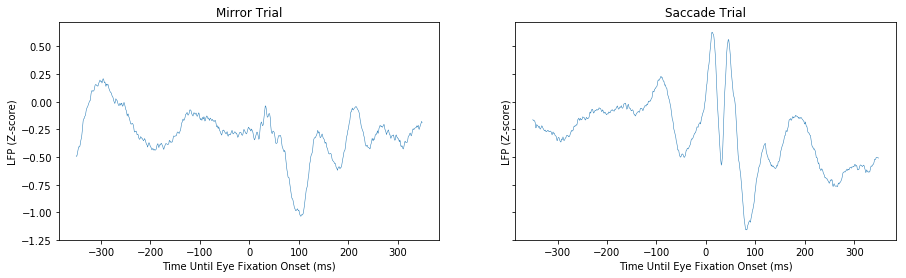

In [37]:
channel = 0
import matplotlib.pyplot as plt
mean_saccade = np.zeros((len(X_trials[0]), dimensions))
mean_mirror = np.zeros((len(X_trials[0]), dimensions))
for key in X_trials:
    if y_trials[key][0] == 0:
        mean_mirror += X_trials[key][:, :dimensions]
    else:
        mean_saccade += X_trials[key][:, :dimensions]
mean_mirror /= mirror_counts
mean_saccade /= saccade_counts
times = [i for i in range(-350, 350)]
fig, axs = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (15, 4))
axs[0].plot(times, mean_mirror[:, channel], linewidth = .5)
axs[1].set_xlabel("Time Until Eye Fixation Onset (ms)")
axs[0].set_xlabel("Time Until Eye Fixation Onset (ms)")
axs[0].set_ylabel("LFP (Z-score)")
axs[1].set_ylabel("LFP (Z-score)")
axs[0].set_title("Mirror Trial")
axs[1].set_title("Saccade Trial")
axs[1].plot(times, mean_saccade[:, channel], linewidth = .5)
plt.savefig("mirror_saccade_eda")
plt.show()
    

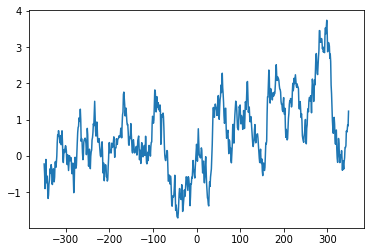

In [38]:
plt.plot(times, X_trials[0][:,channel])
plt.show()

# Error Evaluation

## Accuracy Plot by time point in trial

TypeError: ('Keyword argument not understood:', 'time_major')

<Figure size 432x288 with 0 Axes>

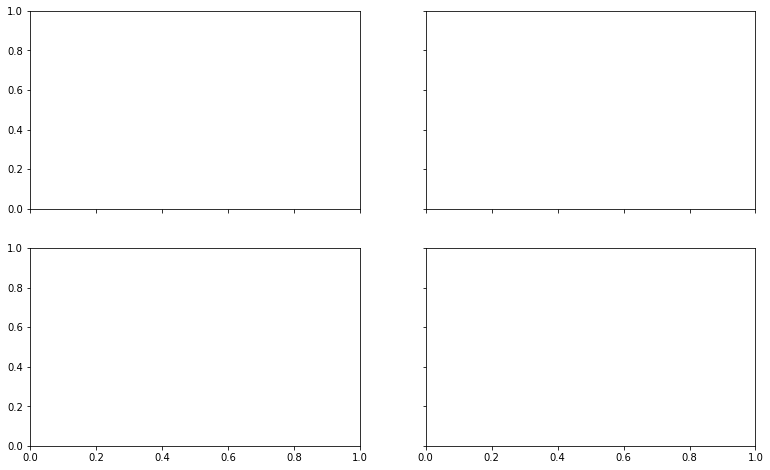

In [39]:
from sklearn import metrics
import matplotlib.pyplot as plt
timestep_array = [100, 50, 20, 10]
accs = []
avgs = []
X_train = 0
y_train = 0
X_val = 0
y_val = 0
X_test = 0
y_test = 0
trial_sequences = 0
trial_targets = 0
plt.figure()
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (13, 8))
for timesteps, ax in zip(timestep_array, axs.flatten()):
    model = models.load_model('mirror_saccade_models/mdl_' + str(timesteps) + '.h5')
    X_trials, y_trials = create_trials(data, window_size, num_trials, steps_per_trial, center = center, 
                                   timestep_encoding = timestep_encoding, bin_size = bin_size)
    X_trials, means, stds = normalize_trials(X_trials, train_inds, dimensions)
    trial_sequences, trial_targets, _, _, _, _, _, _ =\
    create_sequences(X_trials, y_trials, train_inds, test_inds, val_inds, timesteps)
    seq_length = trial_targets[0].shape[0]
    acc = np.zeros(seq_length)
    for ind in test_inds:
        y_true = trial_targets[ind]
        y_pred = model.predict(trial_sequences[ind])
        y_pred = np.array([0 if x < .5 else 1 for x in y_pred])
        acc += 1 - np.square(y_true - y_pred)
    acc /= len(test_inds)
    accs.append(acc)
    avgs.append(np.mean(acc))
    times = np.array([i for i in range(seq_length)])
    times = times - int((seq_length)/2) + center
    pos = int(str(2))
    ax.plot(times, acc, linewidth = .5)
    ax.set_title("Timesteps = " + str(timesteps))
    ax.set_xlabel("Time Until Eye Fixation Onset(ms)")
    ax.set_ylabel("Accuracy")
    print(timesteps)
plt.legend()
plt.savefig("timestep_accuracy")
plt.show()
print(avgs)

# ROC Plot

100
50
20
10


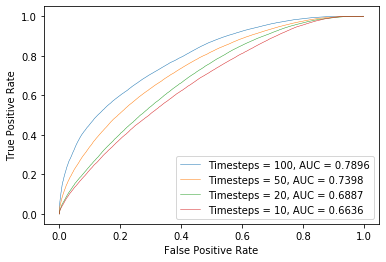

In [17]:
from sklearn import metrics
import matplotlib.pyplot as plt
#times = np.array([i for i in range(window_size - timesteps +1)])
#times = times - (window_size - timesteps + 1)/2 + center
timestep_array = [100, 50, 20, 10]
accs = []
avgs = []
X_train = 0
y_train = 0
X_val = 0
y_val = 0
X_test = 0
y_test = 0
trial_sequences = 0
trial_targets = 0
rocs = []
plt.figure()
for timesteps in timestep_array:
    model = models.load_model('mirror_saccade_models/mdl_' + str(timesteps) + '.h5')
    X_trials, y_trials = create_trials(data, window_size, num_trials, steps_per_trial, center = center, 
                                   timestep_encoding = timestep_encoding, bin_size = bin_size)
    X_trials, means, stds = normalize_trials(X_trials, train_inds, dimensions)
    trial_sequences, trial_targets, _, _, X_test, y_test, _, _ =\
    create_sequences(X_trials, y_trials, train_inds, test_inds, val_inds, timesteps)
    y_pred = model.predict(X_test)
    seq_length = trial_targets[0].shape[0]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth = .5, label = 'Timesteps = ' + str(timesteps) + ', AUC = ' +"{:.4f}".format(auc))
    print(timesteps)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("Roc_by_timesteps")
plt.show()

# AUC By Time

<Figure size 432x288 with 0 Axes>

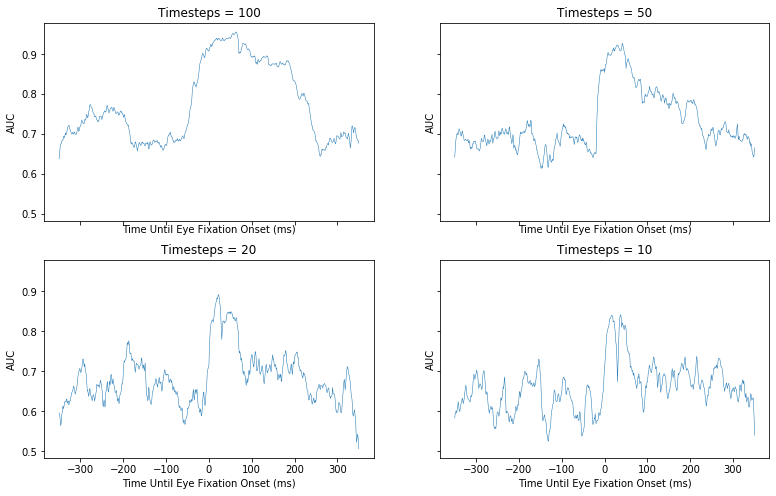

In [18]:
from sklearn import metrics
import matplotlib.pyplot as plt
#times = np.array([i for i in range(window_size - timesteps +1)])
#times = times - (window_size - timesteps + 1)/2 + center
timestep_array = [100, 50, 20, 10]
X_train = 0
y_train = 0
X_val = 0
y_val = 0
X_test = 0
y_test = 0
trial_sequences = 0
trial_targets = 0
plt.figure()
fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize = (13, 8))
for timesteps, ax in zip(timestep_array, axs.flatten()):
    model = models.load_model('mirror_saccade_models/mdl_' + str(timesteps) + '.h5')
    X_trials, y_trials = create_trials(data, window_size, num_trials, steps_per_trial, center = center, 
                                   timestep_encoding = timestep_encoding, bin_size = bin_size)
    X_trials, means, stds = normalize_trials(X_trials, train_inds, dimensions)
    trial_sequences, trial_targets, _, _, _, _, _, _ =\
    create_sequences(X_trials, y_trials, train_inds, test_inds, val_inds, timesteps)
    seq_length = trial_targets[0].shape[0]
    y_tests = []
    y_preds = []
    for ind in test_inds:
        y_tests.append(trial_targets[ind])
        y_preds.append(model.predict(trial_sequences[ind]))
    y_tests = np.array(y_tests)
    y_preds = np.array(y_preds)
    auc = np.zeros(seq_length)
    for i in range(seq_length):
        fpr, tpr, _ = metrics.roc_curve(y_tests[:, i], y_preds[:, i])
        auc[i] = metrics.auc(fpr, tpr)
    times = np.array([i for i in range(seq_length)])
    times = times - int((seq_length)/2) + center
    ax.plot(times, auc, linewidth = .5)
    ax.set_title("Timesteps = " + str(timesteps))
    ax.set_xlabel("Time Until Eye Fixation Onset (ms)")
    ax.set_ylabel("AUC")
plt.savefig("auc_by_time")
plt.show()

# ROC For 0 - 100 Window

In [14]:
# plots the ROC curve, exclusively for data centered around +0 to +100 ms after eye fixation onset. 
from sklearn import metrics
import matplotlib.pyplot as plt
#times = np.array([i for i in range(window_size - timesteps +1)])
#times = times - (window_size - timesteps + 1)/2 + center
timestep_array =  [100, 50, 20, 10]
X_train = 0
y_train = 0
X_val = 0
y_val = 0
X_test = 0
y_test = 0
trial_sequences = 0
trial_targets = 0
plt.figure()
for timesteps in timestep_array:
    model = models.load_model('mirror_saccade_models/mdl_' + str(timesteps) + '.h5')
    X_trials, y_trials = create_trials(data, window_size, num_trials, steps_per_trial, center = center, 
                                   timestep_encoding = timestep_encoding, bin_size = bin_size)
    X_trials, means, stds = normalize_trials(X_trials, train_inds, dimensions)
    trial_sequences, trial_targets, _, _, _, _, _, _ =\
    create_sequences(X_trials, y_trials, train_inds, test_inds, val_inds, timesteps)
    seq_length = trial_targets[0].shape[0]
    y_tests = np.zeros(100 * len(test_inds))
    y_preds = np.zeros(100 * len(test_inds))
    trial_start = int(seq_length/2)
    trial_end = trial_start + 100
    i = 0
    for ind in test_inds:
        start = i * 100
        end = (i + 1) * 100
        y_tests[start:end] = trial_targets[ind][trial_start:trial_end]
        y_preds[start:end] = np.squeeze(model.predict(trial_sequences[ind][trial_start:trial_end]))
        i += 1
    fpr, tpr, _ = metrics.roc_curve(y_tests, y_preds)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth = .5, label = "Timesteps = " + str(timesteps) + ", " + "AUC = " + 
         "{:.4f}".format(auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig("roc_best_window")
plt.show()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


<Figure size 640x480 with 1 Axes>